In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import ImageGrab
import time

In [2]:
import torch
torch.cuda.is_available()

False

In [14]:
# Permet de récuperer des images en réalisant des captures d'écran
# Cette fonction sera supprimé par la suite, mais permet de tester le modèle temporairement 

def test_recuperation_image() :
    i = 0
    screenshots = []
    while (i<200) :
        screenshot = ImageGrab.grab()
        screenshots.append(screenshot)
        i += 1
    return screenshots

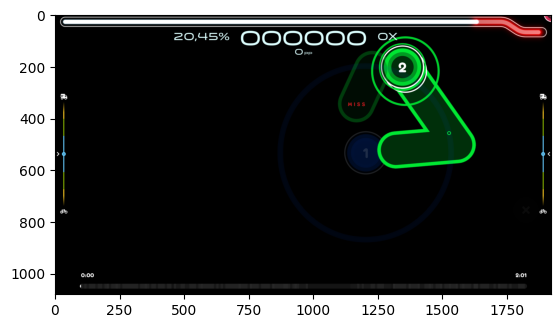

In [19]:
# A supprimer, verification du fonctionnement
screenshots = test_recuperation_image()

imgplot = plt.imshow(screenshots[-1])
plt.show()

Tout écrire en pytorch

Application de conv2d (CNN) sur les images

In [31]:
# Permet de transfomer une matrice (d'une image) en une matrice d'une colone
# Pour l'application d'un réseau de neurone par la suite

def flatten_image(contours_image):
    # Aplatir l'image en une seule colonne
    flattened_image = contours_image.flatten()

    # Renvoyer la matrice aplatie
    return flattened_image

In [33]:
import torch.nn.functional as F
from PIL import Image

# Permet de réaliser la detection de contour d'une seule image

def contour_detection_one_image(image) :

    # Convertir en niveaux de gris
    image_gray = image.convert("L")

    # Convertir en un tableau NumPy
    image_array = np.array(image_gray)

    # Convertir en un tenseur PyTorch
    image_tensor = torch.unsqueeze(torch.unsqueeze(torch.tensor(image_array, dtype=torch.float32), 0), 0)

    # Définir un filtre pour la détection de contours (Sobel filter)
    sobel_filter_x = torch.tensor([[1, 0, -1],
                                    [2, 0, -2],
                                    [1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3)

    sobel_filter_y = torch.tensor([[1, 2, 1],
                                    [0, 0, 0],
                                    [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3)

    # Appliquer conv2d pour détecter les contours en utilisant les filtres Sobel
    contours_x = F.conv2d(image_tensor, sobel_filter_x, padding=1)  # Ajout de padding pour garder la même taille
    contours_y = F.conv2d(image_tensor, sobel_filter_y, padding=1)

    # Calculer le gradient du contour
    gradient_magnitude = torch.sqrt(contours_x ** 2 + contours_y ** 2)

    # Seuiller l'image pour obtenir des contours binaires
    seuil = 0.5  # Vous pouvez ajuster ce seuil en fonction de votre capture d'écran
    contours_binaires = (gradient_magnitude > seuil).float()

    contours_image = contours_binaires.squeeze().numpy()

    flattened_image = flatten_image(contours_image)

    return image_array, contours_image, flattened_image


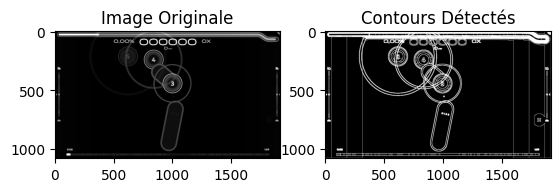

Image flatten:
[1. 1. 1. ... 1. 1. 1.]
Dimensions de l'image flatten: (2073600,)


In [34]:
# A supprimer, test de la fonction contour_detection_one_image

# Appel de la fonction de capture d'écran, et récupération de ces captures
screenshots = test_recuperation_image()

# Récupérer la dernière capture d'écran
image_test = screenshots[-1]

image_final_test, contours_image_test, flattened_image = contour_detection_one_image(image_test)

# Afficher l'image originale et les contours détectés
plt.subplot(1, 2, 1)
plt.imshow(image_final_test, cmap='gray')
plt.title('Image Originale')

plt.subplot(1, 2, 2)
plt.imshow(contours_image_test, cmap='gray')
plt.title('Contours Détectés')
plt.show()


# Afficher l'image flatten
print("Image flatten:")
print(flattened_image)

# Afficher les dimensions de l'image flatten
print("Dimensions de l'image flatten:", flattened_image.shape)

In [12]:
# Permet de réaliser une détection de contour sur un tableau d'image 
# Je pense sera à supprimer

def contour_detection_table_image(images) :

    # Initialisation pour enregistrer les images qui ont été traitées, et les images des contours 
    images_final = []
    contours_images = []

    # Application de la méthode de détection de contour à toutes mes images
    for image in images : 
        image_final, contours_image = contour_detection_one_image(image)

        # Enregistrement de l'image traitée et de a détection de contour dans les tableaux
        images_final.append(image_final)
        contours_images.append(contours_image)

    return images_final, contours_images

In [26]:
# A supprimer, teste de la méthode contour_detection_table_image

screenshots = test_recuperation_image()
images_final, contours_images = contour_detection_table_image(screenshots)

# Afficher l'image originale et les contours détectés
plt.subplot(1, 2, 1)
plt.imshow(images_final[100], cmap='gray')
plt.title('Image Originale')

plt.subplot(1, 2, 2)
plt.imshow(contours_images[100], cmap='gray')
plt.title('Contours Détectés')
plt.show()

# Afficher l'image originale et les contours détectés
plt.subplot(1, 2, 1)
plt.imshow(images_final[-1], cmap='gray')
plt.title('Image Originale')

plt.subplot(1, 2, 2)
plt.imshow(contours_images[-1], cmap='gray')
plt.title('Contours Détectés')
plt.show()